In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy
from time import time
from tqdm import tqdm

In [3]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [4]:
from utils.tools import *

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constants

In [5]:
INPUT_DIM = 50
BIAS = False

SEED = 42
N_TRAIN = 256
BATCH_SIZE = 64
ALPHA = 1e-1
BASE_LR = 1.0e-2
N_STEPS = int(1e4)
N_VAL = 100
VAL_ITER = 100

In [6]:
FIGURES_DIR = os.path.join(ROOT, 'figures/training/')
create_dir(FIGURES_DIR)

In [7]:
set_random_seeds(SEED)

# Data

In [8]:
def forward(a, b, x):
    return np.matmul(np.maximum(np.matmul(x, b.T), 0), a.T)  / a.shape[1] 

In [9]:
# Teacher Network
m = 50 # number of teacher neurons
eps = 3e-1

a_star = 5 * np.sign(np.random.uniform(size=(1, m)) - 0.5) / m
b_star = 2 * np.random.uniform(size=(m, INPUT_DIM)) - 1 - eps * np.random.normal(size=(m, INPUT_DIM))**2

In [10]:
# Data
x_train = np.random.normal(size=(N_TRAIN, INPUT_DIM))
y_train = forward(a_star, b_star, x_train)

x_val = np.random.normal(size=(N_VAL, INPUT_DIM))
y_val = forward(a_star, b_star, x_val)

# Algorithm iterations

In [11]:
def relu_prime(z):
    return (np.sign(z) + 1) / 2

In [12]:
def sample_neurons(n_samples=1):
    return np.random.normal(size=(n_samples, INPUT_DIM))

In [13]:
def forward_states(a, b, x):
    h_1 = np.matmul(x, b.T)
    x_1 = np.maximum(h_1, 0)
    y_hat = np.matmul(x_1, a.T) / a.shape[1]
    
    return h_1, x_1, y_hat

In [14]:
def initialize_neurons(x, y, n_neurons=1):
    # empty arrays and null prediction function
    a = np.array([[]])
    b = np.array([[]])
    y_hat = 0
    
    b_hat = sample_neurons(n_samples=n_neurons)
    x_1 = np.maximum(np.matmul(x, b_hat.T), 0)
    a_hat = ALPHA * np.mean((y - y_hat) * x_1, axis=0)
    
    a = np.append(a, a_hat).reshape(1, n_neurons)
    b = np.append(b, b_hat).reshape(n_neurons, -1)
    
    return a, b 

In [15]:
def update(a, b, x, y, n_updates=1, compute_loss=True):
    for _ in range(n_updates):
        h_1, x_1, y_hat = forward_states(a, b, x)
        delta = y_hat - y
        dh_1 = relu_prime(h_1)
        dh = np.matmul(relu_prime(h_1), np.diag(a.reshape(-1))).T
        b = b - BASE_LR * np.matmul(dh, 
                                    delta * x_train) / N_TRAIN
        a = a - BASE_LR * np.mean(delta * x_1, axis=0)
        
        if compute_loss:
            loss = 0.5 * np.mean(delta**2)
        else:
            loss = -1.0
        
    return a, b, loss

In [16]:
def initialize_net(x, y, n_neurons=1):
    # initialize neurons  y sampling and setting weights accordingly
    a, b = initialize_neurons(x, y, n_neurons=n_neurons)
    print(a)
    print(b)
    
    # return as initialization for the network the first update for the sampled neurons / weights
    return update(a, b, x, y)

In [17]:
def train(n_steps, a, b, x_train, y_train, x_val, y_val, do_val=True, n_samples=1, n_updates=1):
    train_losses = []
    val_losses = []
    
    for i in tqdm(range(n_steps)):
        # sample neurons and set weights
        if n_samples > 0:
            b_hat = sample_neurons(n_samples=n_samples)
            x_1 = np.maximum(np.matmul(x_train, b_hat.T), 0)
            a_hat = ALPHA * np.mean((y_train - y_hat).reshape(-1, 1) * x_1, axis=0)

            # add newly sampled neurons / weights to the list
            a = np.append(a, a_hat)
            b = np.append(b, b_hat).reshape(n_neurons, -1)
        
        # update neurons / weights
        a, b, train_loss = update(a, b, x_train, y_train, n_updates=n_updates)
        train_losses.append(train_loss)
        
        # validation loop if do_val is True
        if do_val:
            if i % VAL_ITER == 0:
                y_hat = forward(a, b, x_val)
                val_loss = 0.5 * np.mean((y_hat - y_val) ** 2)
                val_losses.append(val_loss)
                print('Train loss at step {:,} : {:.5f}'.format(i, train_loss))
                print('Validation loss at step {:,} : {:.5f}'.format(i, val_loss))
                
    return a, b, np.array(train_losses), np.array(val_losses)

In [18]:
# FULL LOOP (standard training with sampling only in the begining)
n_neurons = 100

#a = 0.1 * np.sign(np.random.uniform(size=(1, n_neurons)) - 0.5)
#b = np.random.normal(size=(n_neurons, INPUT_DIM))
n_neurons = 100
n_updates = 1

a, b, _ = initialize_net(x_train, y_train, n_neurons=n_neurons)

[[-0.01045231 -0.0060528  -0.00587544 -0.01030278 -0.00757589 -0.00338248
  -0.00460693 -0.00684729 -0.0062076  -0.0065604  -0.00555076 -0.00528056
  -0.00678202 -0.00696505 -0.00549794 -0.00563308 -0.00795218 -0.00591186
  -0.00827073 -0.00213012 -0.00579403 -0.00624625 -0.00171739 -0.0023881
  -0.00653625 -0.00824928 -0.00687752 -0.00402935 -0.00758971 -0.00577879
  -0.00518    -0.00881908 -0.00548397 -0.00397959 -0.00300308 -0.0083578
  -0.00505637 -0.00557573 -0.00908788 -0.00845874 -0.00479064 -0.00551754
  -0.00310577 -0.00609059 -0.00642652 -0.00449688 -0.0097256  -0.00958711
  -0.00768792 -0.00247384 -0.01000793 -0.00471574 -0.00321967 -0.00426684
  -0.00455058 -0.00523933 -0.00555921 -0.00566596 -0.00698063 -0.007047
  -0.0064502  -0.00627772 -0.00564793 -0.00446238 -0.00705463 -0.00413091
  -0.00701399 -0.00747752 -0.00684138 -0.01033706 -0.00608297 -0.00542079
  -0.00306467 -0.00638831 -0.00313089 -0.0067449  -0.0113867  -0.00622989
  -0.00485801 -0.00251099 -0.00405468 -0.0

In [19]:
a, b, train_losses, val_losses = train(N_STEPS, a, b, x_train, y_train, x_val, y_val, n_samples=0)

  0%|                                       | 22/10000 [00:00<00:45, 218.90it/s]

Train loss at step 0 : 0.00082
Validation loss at step 0 : 0.00067


  3%|█                                     | 273/10000 [00:00<00:12, 793.30it/s]

Train loss at step 100 : 0.00060
Validation loss at step 100 : 0.00052
Train loss at step 200 : 0.00050
Validation loss at step 200 : 0.00047
Train loss at step 300 : 0.00043
Validation loss at step 300 : 0.00045


  5%|█▉                                    | 510/10000 [00:00<00:12, 773.38it/s]

Train loss at step 400 : 0.00039
Validation loss at step 400 : 0.00045
Train loss at step 500 : 0.00036
Validation loss at step 500 : 0.00045


  7%|██▊                                   | 738/10000 [00:01<00:13, 700.17it/s]

Train loss at step 600 : 0.00034
Validation loss at step 600 : 0.00046
Train loss at step 700 : 0.00032
Validation loss at step 700 : 0.00046


  9%|███▎                                  | 873/10000 [00:01<00:14, 618.56it/s]

Train loss at step 800 : 0.00031
Validation loss at step 800 : 0.00047
Train loss at step 900 : 0.00030
Validation loss at step 900 : 0.00048


 11%|████                                 | 1084/10000 [00:01<00:13, 673.47it/s]

Train loss at step 1,000 : 0.00029
Validation loss at step 1,000 : 0.00048
Train loss at step 1,100 : 0.00028
Validation loss at step 1,100 : 0.00049


 13%|████▊                                | 1295/10000 [00:01<00:14, 590.80it/s]

Train loss at step 1,200 : 0.00027
Validation loss at step 1,200 : 0.00049
Train loss at step 1,300 : 0.00027
Validation loss at step 1,300 : 0.00050


 15%|█████▋                               | 1536/10000 [00:02<00:11, 744.29it/s]

Train loss at step 1,400 : 0.00026
Validation loss at step 1,400 : 0.00050
Train loss at step 1,500 : 0.00026
Validation loss at step 1,500 : 0.00051


 17%|██████▏                              | 1688/10000 [00:02<00:12, 670.16it/s]

Train loss at step 1,600 : 0.00025
Validation loss at step 1,600 : 0.00051
Train loss at step 1,700 : 0.00025
Validation loss at step 1,700 : 0.00051


 19%|███████▏                             | 1944/10000 [00:02<00:10, 801.72it/s]

Train loss at step 1,800 : 0.00024
Validation loss at step 1,800 : 0.00052
Train loss at step 1,900 : 0.00024
Validation loss at step 1,900 : 0.00052


 21%|███████▊                             | 2108/10000 [00:03<00:10, 763.67it/s]

Train loss at step 2,000 : 0.00024
Validation loss at step 2,000 : 0.00052
Train loss at step 2,100 : 0.00023
Validation loss at step 2,100 : 0.00053


 23%|████████▎                            | 2257/10000 [00:03<00:12, 639.85it/s]

Train loss at step 2,200 : 0.00023
Validation loss at step 2,200 : 0.00053
Train loss at step 2,300 : 0.00023
Validation loss at step 2,300 : 0.00053


 25%|█████████▎                           | 2522/10000 [00:03<00:11, 636.85it/s]

Train loss at step 2,400 : 0.00023
Validation loss at step 2,400 : 0.00053
Train loss at step 2,500 : 0.00022
Validation loss at step 2,500 : 0.00054


 27%|█████████▉                           | 2682/10000 [00:03<00:10, 714.05it/s]

Train loss at step 2,600 : 0.00022
Validation loss at step 2,600 : 0.00054
Train loss at step 2,700 : 0.00022
Validation loss at step 2,700 : 0.00054


 29%|██████████▊                          | 2927/10000 [00:04<00:09, 771.74it/s]

Train loss at step 2,800 : 0.00022
Validation loss at step 2,800 : 0.00054
Train loss at step 2,900 : 0.00022
Validation loss at step 2,900 : 0.00055


 31%|███████████▍                         | 3102/10000 [00:04<00:08, 827.09it/s]

Train loss at step 3,000 : 0.00022
Validation loss at step 3,000 : 0.00055
Train loss at step 3,100 : 0.00021
Validation loss at step 3,100 : 0.00055


 34%|████████████▍                        | 3366/10000 [00:04<00:08, 814.99it/s]

Train loss at step 3,200 : 0.00021
Validation loss at step 3,200 : 0.00055
Train loss at step 3,300 : 0.00021
Validation loss at step 3,300 : 0.00055


 36%|█████████████▏                       | 3553/10000 [00:04<00:07, 871.06it/s]

Train loss at step 3,400 : 0.00021
Validation loss at step 3,400 : 0.00056
Train loss at step 3,500 : 0.00021
Validation loss at step 3,500 : 0.00056


 37%|█████████████▊                       | 3740/10000 [00:05<00:07, 848.73it/s]

Train loss at step 3,600 : 0.00021
Validation loss at step 3,600 : 0.00056
Train loss at step 3,700 : 0.00021
Validation loss at step 3,700 : 0.00056


 39%|██████████████▌                      | 3936/10000 [00:05<00:06, 913.76it/s]

Train loss at step 3,800 : 0.00020
Validation loss at step 3,800 : 0.00056
Train loss at step 3,900 : 0.00020
Validation loss at step 3,900 : 0.00057


 41%|███████████████▏                     | 4120/10000 [00:05<00:06, 875.99it/s]

Train loss at step 4,000 : 0.00020
Validation loss at step 4,000 : 0.00057
Train loss at step 4,100 : 0.00020
Validation loss at step 4,100 : 0.00057


 43%|███████████████▉                     | 4311/10000 [00:05<00:06, 882.00it/s]

Train loss at step 4,200 : 0.00020
Validation loss at step 4,200 : 0.00057
Train loss at step 4,300 : 0.00020
Validation loss at step 4,300 : 0.00057
Train loss at step 4,400 : 0.00020
Validation loss at step 4,400 : 0.00057


 46%|█████████████████                    | 4605/10000 [00:06<00:05, 947.51it/s]

Train loss at step 4,500 : 0.00020
Validation loss at step 4,500 : 0.00057
Train loss at step 4,600 : 0.00020
Validation loss at step 4,600 : 0.00058


 48%|█████████████████▊                   | 4801/10000 [00:06<00:05, 959.94it/s]

Train loss at step 4,700 : 0.00020
Validation loss at step 4,700 : 0.00058
Train loss at step 4,800 : 0.00019
Validation loss at step 4,800 : 0.00058


 51%|██████████████████▊                  | 5097/10000 [00:06<00:05, 963.06it/s]

Train loss at step 4,900 : 0.00019
Validation loss at step 4,900 : 0.00058
Train loss at step 5,000 : 0.00019
Validation loss at step 5,000 : 0.00058


 53%|███████████████████▌                 | 5295/10000 [00:06<00:04, 971.47it/s]

Train loss at step 5,100 : 0.00019
Validation loss at step 5,100 : 0.00058
Train loss at step 5,200 : 0.00019
Validation loss at step 5,200 : 0.00058


 54%|███████████████████▉                 | 5393/10000 [00:07<00:04, 934.97it/s]

Train loss at step 5,300 : 0.00019
Validation loss at step 5,300 : 0.00059
Train loss at step 5,400 : 0.00019
Validation loss at step 5,400 : 0.00059


 57%|████████████████████▉                | 5675/10000 [00:07<00:05, 855.01it/s]

Train loss at step 5,500 : 0.00019
Validation loss at step 5,500 : 0.00059
Train loss at step 5,600 : 0.00019
Validation loss at step 5,600 : 0.00059


 58%|█████████████████████▎               | 5762/10000 [00:07<00:05, 767.73it/s]

Train loss at step 5,700 : 0.00019
Validation loss at step 5,700 : 0.00059
Train loss at step 5,800 : 0.00019
Validation loss at step 5,800 : 0.00059


 60%|██████████████████████▏              | 6011/10000 [00:07<00:05, 765.21it/s]

Train loss at step 5,900 : 0.00019
Validation loss at step 5,900 : 0.00059
Train loss at step 6,000 : 0.00019
Validation loss at step 6,000 : 0.00059


 62%|██████████████████████▊              | 6179/10000 [00:08<00:05, 748.04it/s]

Train loss at step 6,100 : 0.00019
Validation loss at step 6,100 : 0.00060
Train loss at step 6,200 : 0.00019
Validation loss at step 6,200 : 0.00060


 64%|███████████████████████▊             | 6434/10000 [00:08<00:04, 789.30it/s]

Train loss at step 6,300 : 0.00018
Validation loss at step 6,300 : 0.00060
Train loss at step 6,400 : 0.00018
Validation loss at step 6,400 : 0.00060


 66%|████████████████████████▍            | 6604/10000 [00:08<00:04, 790.54it/s]

Train loss at step 6,500 : 0.00018
Validation loss at step 6,500 : 0.00060
Train loss at step 6,600 : 0.00018
Validation loss at step 6,600 : 0.00060


 68%|█████████████████████████            | 6785/10000 [00:08<00:03, 815.55it/s]

Train loss at step 6,700 : 0.00018
Validation loss at step 6,700 : 0.00060
Train loss at step 6,800 : 0.00018
Validation loss at step 6,800 : 0.00060


 70%|██████████████████████████           | 7029/10000 [00:09<00:04, 664.40it/s]

Train loss at step 6,900 : 0.00018
Validation loss at step 6,900 : 0.00060
Train loss at step 7,000 : 0.00018
Validation loss at step 7,000 : 0.00061


 72%|██████████████████████████▌          | 7194/10000 [00:09<00:03, 705.97it/s]

Train loss at step 7,100 : 0.00018
Validation loss at step 7,100 : 0.00061
Train loss at step 7,200 : 0.00018
Validation loss at step 7,200 : 0.00061


 74%|███████████████████████████▍         | 7422/10000 [00:09<00:03, 695.88it/s]

Train loss at step 7,300 : 0.00018
Validation loss at step 7,300 : 0.00061
Train loss at step 7,400 : 0.00018
Validation loss at step 7,400 : 0.00061


 76%|████████████████████████████         | 7589/10000 [00:10<00:03, 742.55it/s]

Train loss at step 7,500 : 0.00018
Validation loss at step 7,500 : 0.00061
Train loss at step 7,600 : 0.00018
Validation loss at step 7,600 : 0.00061


 78%|█████████████████████████████        | 7842/10000 [00:10<00:02, 815.51it/s]

Train loss at step 7,700 : 0.00018
Validation loss at step 7,700 : 0.00061
Train loss at step 7,800 : 0.00018
Validation loss at step 7,800 : 0.00061


 80%|█████████████████████████████▋       | 8007/10000 [00:10<00:02, 735.58it/s]

Train loss at step 7,900 : 0.00018
Validation loss at step 7,900 : 0.00061
Train loss at step 8,000 : 0.00018
Validation loss at step 8,000 : 0.00061


 83%|██████████████████████████████▋      | 8286/10000 [00:10<00:01, 865.75it/s]

Train loss at step 8,100 : 0.00017
Validation loss at step 8,100 : 0.00062
Train loss at step 8,200 : 0.00017
Validation loss at step 8,200 : 0.00062


 84%|██████████████████████████████▉      | 8374/10000 [00:10<00:01, 827.92it/s]

Train loss at step 8,300 : 0.00017
Validation loss at step 8,300 : 0.00062
Train loss at step 8,400 : 0.00017
Validation loss at step 8,400 : 0.00062


 86%|███████████████████████████████▉     | 8630/10000 [00:11<00:01, 796.99it/s]

Train loss at step 8,500 : 0.00017
Validation loss at step 8,500 : 0.00062
Train loss at step 8,600 : 0.00017
Validation loss at step 8,600 : 0.00062


 88%|████████████████████████████████▌    | 8812/10000 [00:11<00:01, 849.44it/s]

Train loss at step 8,700 : 0.00017
Validation loss at step 8,700 : 0.00062
Train loss at step 8,800 : 0.00017
Validation loss at step 8,800 : 0.00062


 91%|█████████████████████████████████▌   | 9080/10000 [00:11<00:01, 830.45it/s]

Train loss at step 8,900 : 0.00017
Validation loss at step 8,900 : 0.00062
Train loss at step 9,000 : 0.00017
Validation loss at step 9,000 : 0.00062


 93%|██████████████████████████████████▎  | 9271/10000 [00:12<00:00, 895.33it/s]

Train loss at step 9,100 : 0.00017
Validation loss at step 9,100 : 0.00062
Train loss at step 9,200 : 0.00017
Validation loss at step 9,200 : 0.00062


 95%|███████████████████████████████████  | 9469/10000 [00:12<00:00, 944.33it/s]

Train loss at step 9,300 : 0.00017
Validation loss at step 9,300 : 0.00062
Train loss at step 9,400 : 0.00017
Validation loss at step 9,400 : 0.00063
Train loss at step 9,500 : 0.00017
Validation loss at step 9,500 : 0.00063


 98%|████████████████████████████████████ | 9758/10000 [00:12<00:00, 952.19it/s]

Train loss at step 9,600 : 0.00017
Validation loss at step 9,600 : 0.00063
Train loss at step 9,700 : 0.00017
Validation loss at step 9,700 : 0.00063


100%|████████████████████████████████████| 10000/10000 [00:12<00:00, 778.53it/s]

Train loss at step 9,800 : 0.00017
Validation loss at step 9,800 : 0.00063
Train loss at step 9,900 : 0.00017
Validation loss at step 9,900 : 0.00063


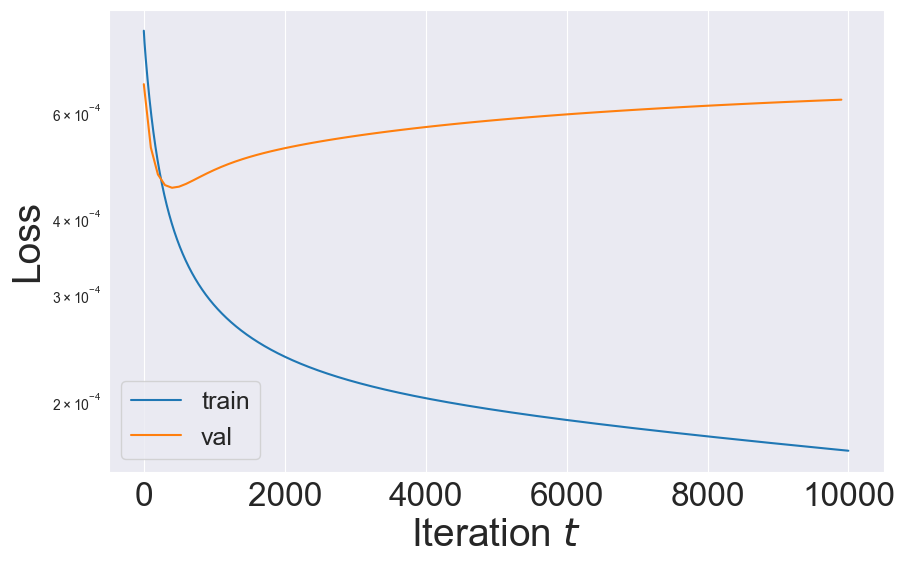

In [20]:
plt.figure(figsize=(10, 6))
marker = None #'o'
#plt.xscale('log')
plt.yscale('log')

plt.plot(np.arange(len(train_losses)), train_losses, label='train')
plt.plot([VAL_ITER * k for k in range(len(val_losses))], val_losses, label='val', marker=marker)

plt.xlabel('Iteration $t$', fontsize=28)
plt.ylabel('Loss', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
#plt.savefig(os.path.join(FIGURES_DIR, 'losses.png'), bbox_inches='tight')
plt.show()